In [25]:
import pandas as pd
from astropy.table import Table
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.coordinates import SkyCoord, angular_separation
import astropy.units as u
from bayestar import SFH
import json
from astropy.modeling import models, fitting

# **Star Formation History**

In [46]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

# **Data**

### **JWST**

In [29]:
regions_dict = {}
with open('regions90.json') as json_file:
    data = json.load(json_file)
    
regions_dict.update(data)

with open('../data/DS9 regions/bubbles.reg') as f:
    dat = f.readlines()
    
bubbles = {}
for n,i in enumerate(dat[3:]):
    ra = float(i.split(',')[0][7:])
    dec = float(i.split(',')[1])
    radius = float(i.split(',')[2].split('"')[0])
    bubbles[f'bubble_{n}'] = {'ra' : ra,
                              'dec': dec,
                              'radius': radius}
regions_dict.update(bubbles) ;

comp_f115w = models.Polynomial1D(2,c0=26.47870176, c1=11.22668675, c2=-47.76591063)
comp_f150w = models.Polynomial1D(2,c0=24.55437017, c1=15.25008677, c2=-50.93756377)
comp_f200w = models.Polynomial1D(2,c0=25.94561544, c1=4.47338118, c2=-79.52827123)

# JWST
Av = 0.19
AF115  =  0.419*Av
AF150  =  0.287*Av
AF200  =  0.195*Av
dismod = 29.7126

In [30]:
tab = Table.read('../photometry/ngc628/f115w_f150w_f200w.fits')
region = 'bubble_0'

In [21]:
sqr_field = False
r_in      = 0
r_out     = 8.9
ang       = 114.99508

ra_cen = regions_dict[region]['ra']
dec_cen = regions_dict[region]['dec']

coords = SkyCoord(ra=tab['ra']*u.degree, dec=tab['dec']*u.degree, frame='icrs')
origin = SkyCoord(ra=ra_cen*u.degree, dec=dec_cen*u.degree, frame='icrs')

# Calculate the position angle and separation from the origin
pos_angle = coords.position_angle(origin)
sep = coords.separation(origin)

# Convert the rotation angle to radians and apply it to the position angle
angle_rad = np.deg2rad(ang)
new_pos_angle = pos_angle + angle_rad*u.radian

# Calculate the new coordinates using the updated position angle and separation
new_coords = origin.directional_offset_by(new_pos_angle, sep)
tab['temp_ra'] = new_coords.ra.value
tab['temp_dec'] = new_coords.dec.value


tab['r'] = angular_separation(tab['temp_ra']*u.deg,tab['temp_dec']*u.deg,
                                  ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

if not sqr_field:
    tab = tab[ (tab['r']>=r_in) & (tab['r'] <r_out)]
else:
    tab = tab[ (tab['temp_ra']>=ra_cen-r_out/3600) & (tab['temp_ra']<=ra_cen+r_out/3600) ]
    tab = tab[ (tab['temp_dec']>=dec_cen-r_out/3600) & (tab['temp_dec']<=dec_cen+r_out/3600) ]

tab.remove_columns(['temp_ra', 'temp_dec'])

In [23]:
df = tab.to_pandas()
df_filt = df.rename(columns = col_dict)

In [24]:
df = tab.to_pandas()
col_dict = {'ra'                 : 'RA',
            'dec'                : 'DEC',
            'mag_vega_F115W'     : 'fw1',
            'mag_err_1'          : 'fw1_error',
            'mag_vega_F150W'     : 'fw2',
            'mag_err_2'          : 'fw2_error',
            'mag_vega_F200W'     : 'fw3',
            'mag_err'            : 'fw3_error'}

In [31]:
fw1_lim = comp_f115w(np.nanmedian(df['crowd_1']))
fw2_lim = comp_f150w(np.nanmedian(df['crowd_2']))
fw3_lim = comp_f200w(np.nanmedian(df['crowd']))

In [33]:
fw1_lim,fw2_lim, fw3_lim

(26.78933375909833, 24.81756357952703, 24.00111360401813)

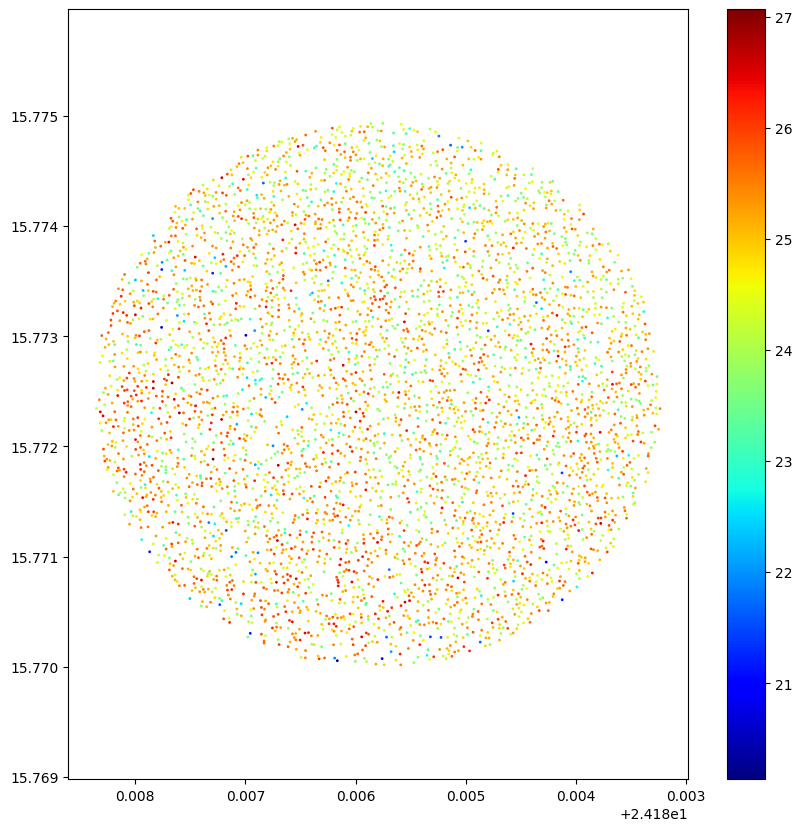

In [41]:
x = df_filt['RA']
y = df_filt['DEC']
c = df_filt['fw1']

fig, ax = plt.subplots(figsize=(10, 10))

img = ax.scatter(x,y,c=c,s=1, cmap='jet')
ax.axis('equal')
cb = plt.colorbar(img)
ax.invert_xaxis()

### **HST**

In [44]:
df = pd.read_fwf("data/test_files/data.test", sep=' ')

col_dict = {
            'F435Wmag'        : 'fw1',
            'F435Wmag_err'    : 'fw1_error',
            'F555Wmag'        : 'fw2',
            'F555Wmag_err'    : 'fw2_error',
            'F814Wmag'        : 'fw3',
            'F814Wmag_err'    : 'fw3_error'}

df_filt = df.rename(columns=col_dict)
Av = 0
AF435 =  1.33879*Av
AF555 =  1.03065*Av
AF814 =  0.59696*Av
dismod = 29.67

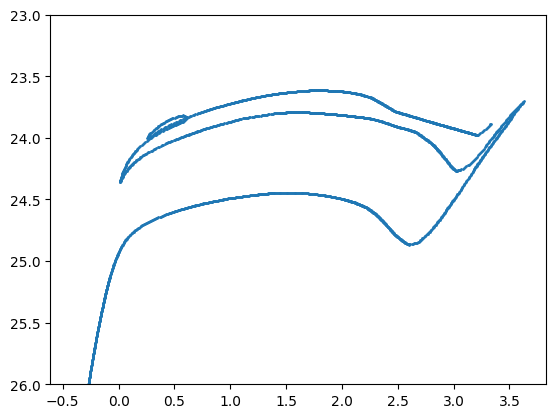

In [59]:
x = df_filt['fw1'] - df_filt['fw3']
y = df_filt['fw3']

fig, ax = plt.subplots()

ax.scatter(x,y,s =1)
ax.set_ylim(23,26)
ax.invert_yaxis()

In [36]:
df = pd.read_csv("../data/isochrones_master/cmd_hst_full.csv")

df = df[(df['logAge']==7.2) | (df['logAge']==7.5) | (df['logAge']==7.8) ]

col_dict = {
            'F435Wmag'        : 'fw1',
            'F435Wmag_err'    : 'fw1_error',
            'F555Wmag'        : 'fw2',
            'F555Wmag_err'    : 'fw2_error',
            'F814Wmag'        : 'fw3',
            'F814Wmag_err'    : 'fw3_error'}

df_filt = df.rename(columns=col_dict)

df_filt['RA'] = 0
df_filt['DEC'] = 0
df_filt['fw1_error'] = 0.01
df_filt['fw2_error'] = 0.01
df_filt['fw3_error'] = 0.01

Av = 0
AF435 =  1.33879*Av
AF555 =  1.03065*Av
AF814 =  0.59696*Av

### **JWST**

In [80]:
df = pd.read_csv("../data/isochrones_master/cmd_jwst_full.csv")

In [81]:
df_filt  = df[df['logAge']==7.6][['F115Wmag', 'F150Wmag', 'F200Wmag']]

df_filt['RA'] = 0
df_filt['DEC'] = 0
df_filt['fw1_error'] = 0.01
df_filt['fw2_error'] = 0.01
df_filt['fw3_error'] = 0.01


col_dict = {
            'F115Wmag'     : 'fw1',
            'F150Wmag'     : 'fw2',
            'F200Wmag'     : 'fw3'}

# JWST
Av = 0
AF115 =  0.32726*Av
AF150 =  0.21461*Av
AF200 =  0.13589*Av

dismod = 0
df_filt = df_filt.rename(columns = col_dict)

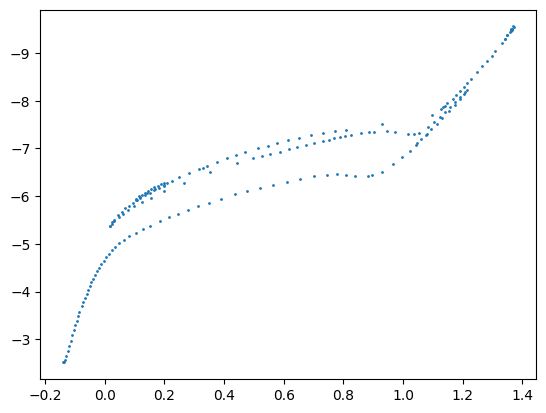

In [82]:
x = df_filt['fw1'] - df_filt['fw3']
y = df_filt['fw3']

fig, ax = plt.subplots()

ax.scatter(x,y,s =1)
ax.invert_yaxis()

# **Run**

## **HST**

In [49]:
# HST
sfh = SFH(df_filt, parallel=True, isodir="../data/isochrones/HST/", 
          fw1_lim=35.,fw2_lim=30, fw3_lim=35.,
          A_fw1=AF435, A_fw2=AF555, A_fw3=AF814,
         dismod=dismod)

Selecting 3278 from 3672... (FW2 <= 30.00)


In [50]:
fname = sfh()

Starting Pij, Cij computation
	Parallel mode...
Finished                                
Elapsed time: 00:00:01


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_kzhpznha/model_4xnllnqo.stan', line 10, column 16: A
    control flow statement inside function P depends on argument v. At
    '/tmp/httpstan_kzhpznha/model_4xnllnqo.stan', line 32, column 30 to
    column 31, the value of v depends on parameter(s): a.
Sampling:   0%
Sampling:   5% (700/14000)
Sampling:  10% (1400/14000)
Sampling:  15% (2100/14000)
Sampling:  20% (2800/14000)
Sampling:  25% (3500/14000)
Sampling:  30% (4200/14000)
Sampling:  35% (4900/14000)
Sampling:  40% (5600/14000)
Sampling:  45% (6300/14000)
Sampling:  50% (7000/14000)
Sampling:  55% (7700/14000)
Sampling:  60% (8400/14000)
Sampling:  65% (9100/14000)
Sampling:  70% (9800/14000)
Sampling:  75% (10500/14000)
Sampling:  80% (11200/14000)
Sampling:  85% (11900/14000)
Sampling:  90% (12600/14000)
Sampling:  95% (13300/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evalu

## **JWST**

In [44]:
# JWST
sfh = SFH(df_filt, parallel=True, isodir='../data/isochrones/JWST/', 
          fw1_lim=fw1_lim,fw2_lim=fw2_lim, fw3_lim=fw3_lim,
          sig_fw1=0.05, sig_fw2=0.05, sig_fw3=0.05,
          A_fw1=AF115, A_fw2=AF150, A_fw3=AF200,
         dismod=dismod)

Selecting 3222 from 4525... (FW1 <= 26.79) (FW2 <= 24.82) (FW3 <= 24.00)


In [47]:
fname = sfh()

Starting Pij, Cij computation
	Parallel mode...


/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/multiprocessing/reduction.py:51: RuntimeWarning: coroutine 'build.<locals>.go' was never awaited
  cls(buf, protocol).dump(obj)


Finished                                
Elapsed time: 00:01:28


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_kzhpznha/model_4xnllnqo.stan', line 10, column 16: A
    control flow statement inside function P depends on argument v. At
    '/tmp/httpstan_kzhpznha/model_4xnllnqo.stan', line 32, column 30 to
    column 31, the value of v depends on parameter(s): a.
Sampling:   0%
Sampling:   5% (700/14000)
Sampling:  10% (1400/14000)
Sampling:  15% (2100/14000)
Sampling:  20% (2800/14000)
Sampling:  25% (3500/14000)
Sampling:  30% (4200/14000)
Sampling:  34% (4800/14000)
Sampling:  39% (5400/14000)
Sampling:  43% (6000/14000)
Sampling:  46% (6500/14000)
Sampling:  49% (6900/14000)
Sampling:  52% (7300/14000)
Sampling:  54% (7501/14000)
Sampling:  55% (7702/14000)
Sampling:  56% (7802/14000)
Sampling:  56% (7803/14000)
Sampling:  56% (7804/14000)
Sampling:  56% (7805/14000)
Sampling:  56% (7806/14000)
Sampling:  56% (7807/14000)
Sampling:  56% (7907/14000)
Sampling:  57% (8007/14000)
Sampling:  58% (8107/14000)
Sampling:

Completed!!!


## **Plot**

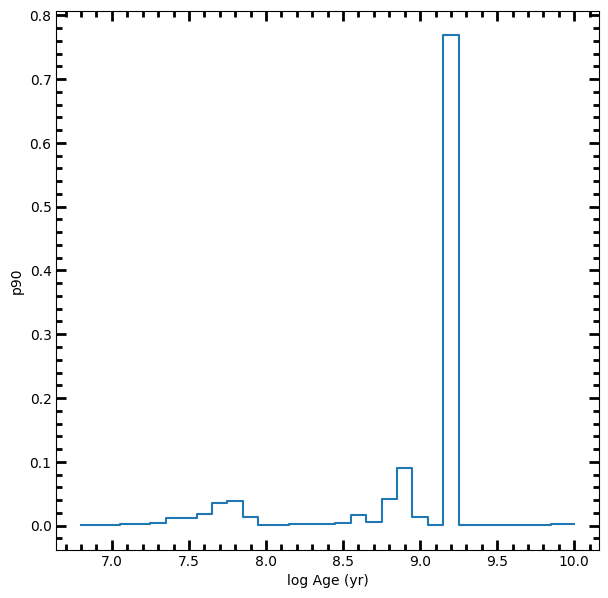

In [49]:
df_out = pd.read_csv(fname)

fig, ax = plt.subplots(figsize=(7,7))

x = df_out['Log_age']
y = df_out['p90']

ax.step(x,y,where='mid')

ax.set_xlabel('log Age (yr)')
ax.set_ylabel('p90')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

In [97]:
P_ij = np.array(sfh.P_ij)
ai = pd.read_csv(fname)['p90'].values
ages = pd.read_csv(fname)['Log_age'].values

In [99]:
P = []
P_age = []
for i in p_age:
    prob = i[i==i.max()]
    ind = np.where(i==i.max())[0][0]
    P.append(prob)
    P_age.append(ages[ind])

In [102]:
df = pd.DataFrame(sfh.dat.T, columns=['RA','DEC','mag_vega_F115W',
                                    'mag_err_1', 'mag_vega_F150W',
                                    'mag_err_2','mag_vega_F200W',
                                    'mag_err'])

In [104]:
df['Prob'] = P
df['Log_Age'] = P_age

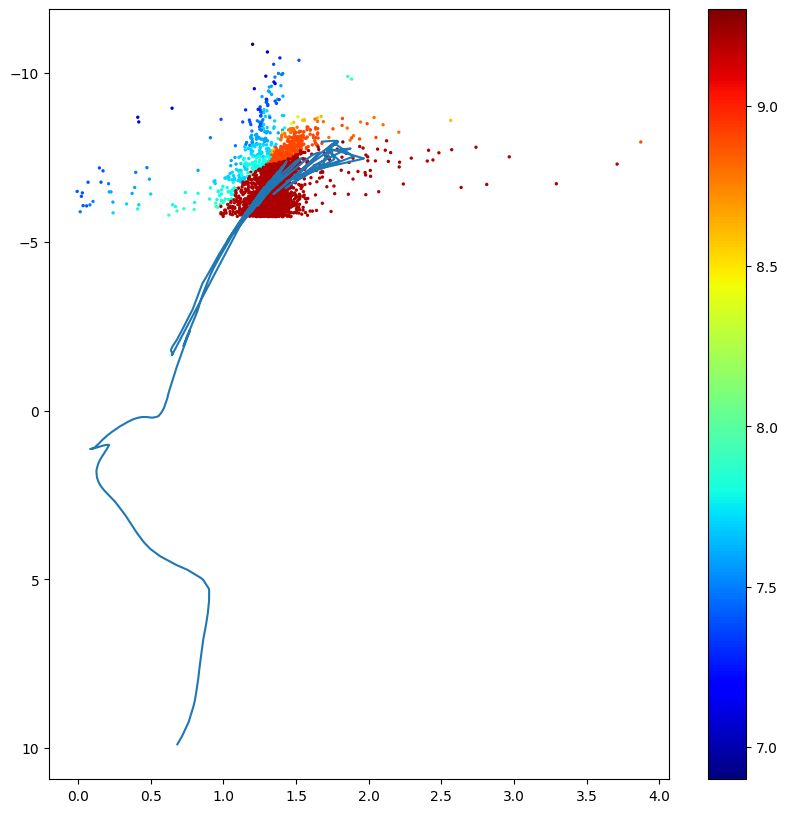

In [118]:
x = df['mag_vega_F115W'] - df['mag_vega_F200W']
y = df['mag_vega_F200W']
c = df['Log_Age']
fig, ax = plt.subplots(figsize=(10, 10))

img = ax.scatter(x,y,c=c,s=2, cmap='jet')
cb = plt.colorbar(img, ax=ax)
ax.invert_yaxis()

ind = 25
ax.plot(sfh.Iso[ind][2]-sfh.Iso[ind][4], sfh.Iso[ind][4])

In [110]:
iso = np.array(sfh.Iso)

In [114]:
iso[0].shape

(7, 2241)

In [117]:
np.where(ages==9.3)

(array([25]),)